<a href="https://colab.research.google.com/github/sethu-7/Sarcasm_Detection/blob/main/Sarcasm_Detction_Roberta_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')
import nltk
nltk.download('omw-1.4')
# generics
import pandas as pd
import numpy as np
import random

# visu
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
# import krono

# texts
import re
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics



import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import tensorflow as tf

tf.__version__


'2.15.0'

In [ ]:
print("GPU", "available (Yess!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Train_Test_Combined_Dataset_tweets_git.csv")
df

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
47606,Jeff Atwood: Learning to code is overrated htt...,0
47607,"Iraq defends intelligence sharing with Russia,...",0
47608,#Lab15 session on the role of #AI #data #machi...,0
47609,#DragonsDen #FunPalace last school #workshop t...,0


In [ ]:
# sarcastic=[]
# df['star_rating']=df['star_rating']

# for i in df['star_rating']:
#   if (i==1):
#     sarcastic.append(0)
#   elif (i==5):
#     sarcastic.append(1)


# print(sarcastic[:100])

In [ ]:
# sarcastic_df = pd.DataFrame(sarcastic, columns=['sarcastic']).astype(int)
# df['sarcastic'] = sarcastic_df

In [ ]:
df['sarcastic']

0        1
1        1
2        1
3        1
4        1
        ..
47606    0
47607    0
47608    0
47609    0
47610    0
Name: sarcastic, Length: 47611, dtype: int64

In [ ]:
class_counts = df['sarcastic'].value_counts()

# Calculate the maximum number of samples among all classes
max_count = class_counts.min()

# Create a DataFrame to store balanced data
balanced_df = pd.DataFrame(columns=['tweet', 'sarcastic'])

# Iterate over each class
for sarcastic, count in class_counts.items():
    # If the class count is greater than the maximum count, remove extra samples randomly
    if count > max_count:
        # Randomly sample rows to keep only the required number of samples
        sampled_rows = df[df['sarcastic'] == sarcastic].sample(n=max_count, random_state=42)
        # Append the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df,sampled_rows])
    else:
        # If the class count is not greater than the maximum count, keep all samples for that class
        balanced_df = pd.concat([balanced_df,df[df['sarcastic'] == sarcastic]])

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
balanced_df.sarcastic.value_counts()

sarcastic
1    22615
0    22615
Name: count, dtype: int64

In [ ]:
!pip install nxviz

# Modeling

In this step we will build, train and compare the following algorithms:

- RoBERTa (Robustly Optimized BERT Pre-training Approach)


In [ ]:
data = balanced_df[['tweet', 'sarcastic']]

# Set your model output as categorical and save in new label col
data['sarcastic_label'] = pd.Categorical(data['sarcastic'])

# Transform your output to numeric
data['sarcastic'] = data['sarcastic_label'].cat.codes

Split into train and validation set, as the file contains more than 150 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [ ]:
data_train, data_val = train_test_split(data, test_size = 0.2)
#data_train, data_val, y_train, y_test = train_test_split(data, test_size=0.3, random_state=0, stratify=Severity)


In [ ]:
data_train.sarcastic.value_counts()

sarcastic
1    18114
0    18070
Name: count, dtype: int64

In [ ]:
data_val.sarcastic.value_counts()

sarcastic
0    4545
1    4501
Name: count, dtype: int64

In [ ]:
es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

In [ ]:
#y_test_array =pd.get_dummies(y_val_actual_max, drop_first=False).values #np.asarray(y_val_actual_max)

#y_score = np.asarray(y_val_pred_max)

# RoBERTa

In [ ]:
import transformers
transformers.__version__

'4.35.0'

In [ ]:
!pip install transformers==4.35.0

In [ ]:
transformers.__version__

'4.35.0'

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig

In [ ]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 40

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
sarcastics = Dense(units=len(data_train.sarcastic_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='sarcastic')(pooled_output)
outputs = {'sarcastic': sarcastics}

# And combine it all in a model object
Robsent = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
Robsent.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 40)]              0         
                                                                 
 roberta (TFRobertaMainLaye  TFBaseModelOutputWithPo   124645632 
 r)                          olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 40, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'sarcastic': CategoricalCrossentropy(from_logits = True)}

# Compile the model
Robsent.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['sarcastic'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['sarcastic'])

x_val = tokenizer(
          text=data_val['tweet'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = Robsent.fit(
    x={'input_ids': x_train['input_ids']},
    y={'sarcastic': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'sarcastic': y_val}),
    batch_size=64,
    epochs=100,
    verbose=1,callbacks=[es])

Epoch 1/100
566/566 [==============================] - 365s 586ms/step - loss: 0.1457 - accuracy: 0.9333 - val_loss: 0.1084 - val_accuracy: 0.9506
Epoch 2/100
566/566 [==============================] - 342s 605ms/step - loss: 0.0978 - accuracy: 0.9564 - val_loss: 0.1006 - val_accuracy: 0.9550
Epoch 3/100
566/566 [==============================] - 343s 606ms/step - loss: 0.0796 - accuracy: 0.9654 - val_loss: 0.1055 - val_accuracy: 0.9553
Epoch 4/100
566/566 [==============================] - 326s 576ms/step - loss: 0.0663 - accuracy: 0.9710 - val_loss: 0.1094 - val_accuracy: 0.9558
Epoch 5/100
566/566 [==============================] - 324s 573ms/step - loss: 0.0552 - accuracy: 0.9777 - val_loss: 0.1151 - val_accuracy: 0.9578
Epoch 6/100
566/566 [==============================] - 324s 572ms/step - loss: 0.0465 - accuracy: 0.9808 - val_loss: 0.1182 - val_accuracy: 0.9559
Epoch 7/100
566/566 [==============================] - 340s 601ms/step - loss: 0.0422 - accuracy: 0.9822 - val_loss: 0

## Evaluate on validation set:

In [ ]:
model_eval = Robsent.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'sarcastic': y_val}
)

283/283 [==============================] - 26s 92ms/step - loss: 0.1621 - accuracy: 0.9616


In [ ]:
y_val_predicted = Robsent.predict(
    x={'input_ids': x_val['input_ids']},
)

In [ ]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['sarcastic']]

In [ ]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [ ]:
y_test_array =pd.get_dummies(y_val_actual_max, drop_first=False).values #np.asarray(y_val_actual_max)


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4674
           1       0.95      0.98      0.96      4372

    accuracy                           0.96      9046
   macro avg       0.96      0.96      0.96      9046
weighted avg       0.96      0.96      0.96      9046



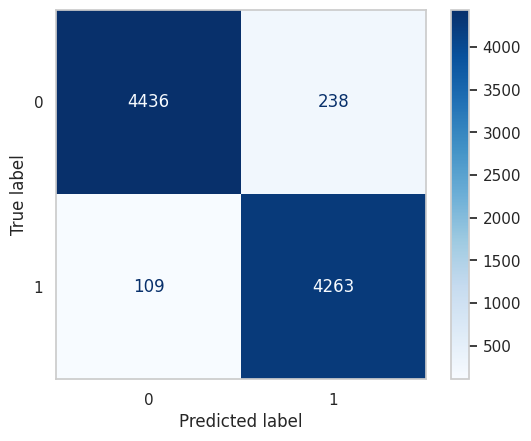

In [ ]:
#@title
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues')
plt.grid(False)

In [ ]:
classes=[0,1]

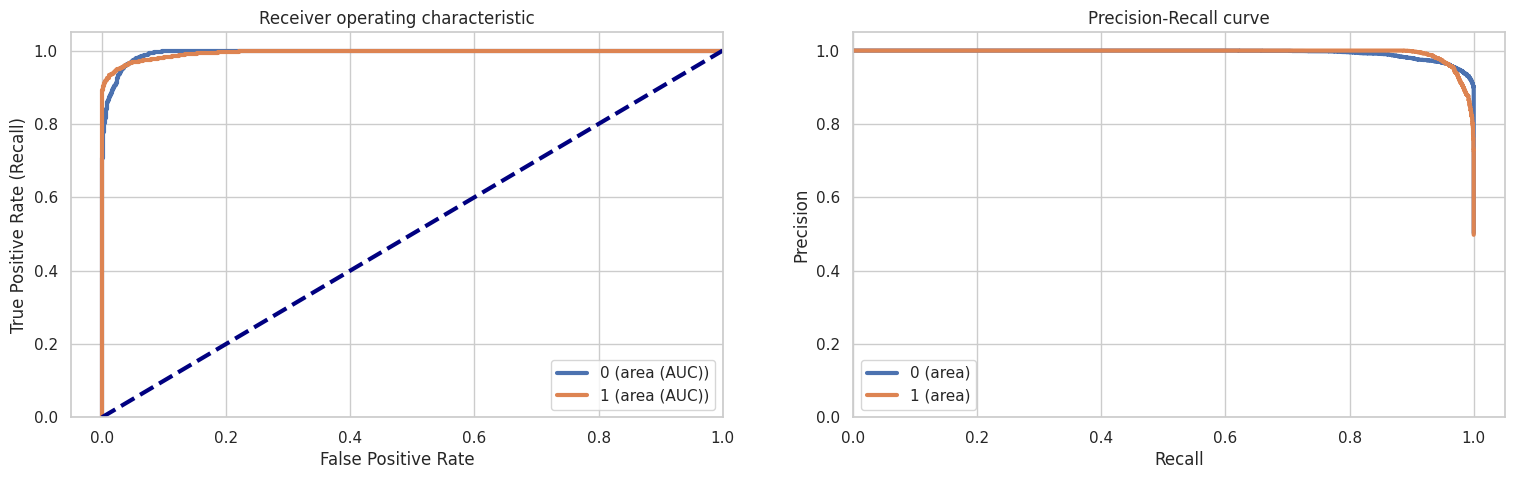

In [ ]:
yv=y_val_predicted["sarcastic"]
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 5)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],yv[:,i])
    ax[0].plot(fpr, tpr, lw=3,
              #label='{0} (area (AUC) = {1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr))
              label='{0} (area (AUC))'.format(classes[i])

               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], yv[:,i])
    ax[1].plot(recall, precision, lw=3,
               #label='{0} (area ={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
               label='{0} (area)'.format(classes[i])

              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()